In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import auc, accuracy_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

In [2]:
# List of all the lineages we will be making dataframes for - some of the DFs don't have a col named depmapid but have depmapids, will require some cleaning
lineages = ["kidney", "breast", "blood", "liver", "urinary_tract", "colorectal", "ovary", "pancreas"]
lineage_df_dict = {}

In [3]:
# List of all the feature dataframes we are going to read into the lineage dataframes
features = ["effect", "dependency", "expression", "gene_cn"]
feature_df_dict = {}

In [4]:
sample_info_df = pd.read_csv('data/sample_info.csv')

In [5]:
folder_path = "data/"

for file_name in os.listdir(folder_path):
    for feature in features:
        if file_name.endswith('.csv') and feature in file_name:
            file_path = os.path.join(folder_path, file_name)
            feature_df_dict[feature] = pd.read_csv(file_path)
            feature_df_dict[feature].columns = [column.split(' ')[0] for column in feature_df_dict[feature].columns]
            feature_df_dict[feature].rename(columns={feature_df_dict[feature].columns[0]: "DepMap_ID"}, inplace=True)
            feature_df_dict[feature] = pd.merge(feature_df_dict[feature], sample_info_df[['DepMap_ID', 'lineage']], on='DepMap_ID', how='left')
            feature_df_dict[feature].drop("DepMap_ID", axis=1, inplace=True)
            feature_df_dict[feature] = feature_df_dict[feature].pivot_table(index='lineage', aggfunc='mean')

In [6]:
for feature in features:
    for lineage in lineages:
        temp_df = feature_df_dict[feature].loc[feature_df_dict[feature].index == lineage].transpose()
        temp_df.index.name = 'gene'
        if lineage in lineage_df_dict:
            temp_df.rename(columns={lineage : feature}, inplace=True)
            lineage_df_dict[lineage] = pd.merge(lineage_df_dict[lineage], temp_df, on="gene", how="outer").dropna()
        else:
            lineage_df_dict[lineage] = pd.DataFrame({feature: temp_df[lineage]}, index=temp_df.index)
            lineage_df_dict[lineage].index.name = 'gene'
            lineage_df_dict[lineage].reset_index(inplace=True)

In [7]:
training_dfs = {}
training_lineages = {"kidney" : "kidney", 
                     "breast" : "breast", 
                     "leukemia" : "blood", 
                     "liver" : "liver", 
                     "bladder" : "urinary_tract",
                     "colon" : "colorectal", 
                     "ovarian" : "ovary", 
                     "pancreatic" : "pancreas"}
for k, v in training_lineages.items():
    # get the df from the training set
    df = pd.read_csv(f"training_sets_genes/{k}_training_genes_set.csv")
    df = df.merge(lineage_df_dict[v], on="gene", how='left').fillna(0)
    
    # drop all training genes from the prediction set
    lineage_df_dict[v] = pd.merge(lineage_df_dict[v], df, indicator=True, how='left', on=list(lineage_df_dict[v].columns)).query('_merge == "left_only"').drop('_merge', axis=1)
    lineage_df_dict[v].drop(columns=['label'], inplace=True)
    df.set_index('gene', inplace=True)
    lineage_df_dict[v].set_index('gene', inplace=True)
    
    # split into 10 samples for 50-50 pos neg split
    samples = []
    for negatives in np.array_split(df[df['label'] == 'negative'], 10):
        samples.append(pd.concat([df[df['label'] == "positive"], negatives]))
    
    training_dfs[k] = samples

/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59

In [9]:
rev_training_lineages = {value: key for key, value in training_lineages.items()}

## Logistic Regression

In [71]:
def train_logistic_regression(X, Y):
    # Get the training and test data
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

    # Fit the model
    model = LogisticRegression().fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_rt = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_rt, pos_label='positive')
    auc_value = auc(fpr, tpr)
    precision = precision_score(y_test, y_pred, pos_label='positive')
    f1score = f1_score(y_test, y_pred, average="weighted")

    return (accuracy, y_test, y_pred, y_pred_rt, model, auc_value, precision, f1score)

In [72]:
stats_by_lineage = {}
for lineage, dfs in training_dfs.items():
    accuracies = []
    auc_vals = [] 
    precisions = []
    f1scores = []
    y_tests = np.array([])
    y_preds = np.array([])
    y_pred_probas = np.array([])
    for df in dfs:
        X = df.drop(['label'], axis=1)
        Y = df['label']
        (accuracy, y_test, y_pred, y_pred_rt, model, auc_value, precision, f1score) = train_logistic_regression(X, Y)
        accuracies.append(accuracy)
        auc_vals.append(auc_value)
        precisions.append(precision)
        recalls.append(recall)
        f1scores.append(f1score)
        y_tests = np.append(y_tests, y_test)
        y_preds = np.append(y_preds, y_pred)
        y_pred_probas = np.append(y_pred_probas, y_pred_rt)
    stats_by_lineage[lineage] = [accuracies, auc_vals, y_tests, y_preds, y_pred_probas]

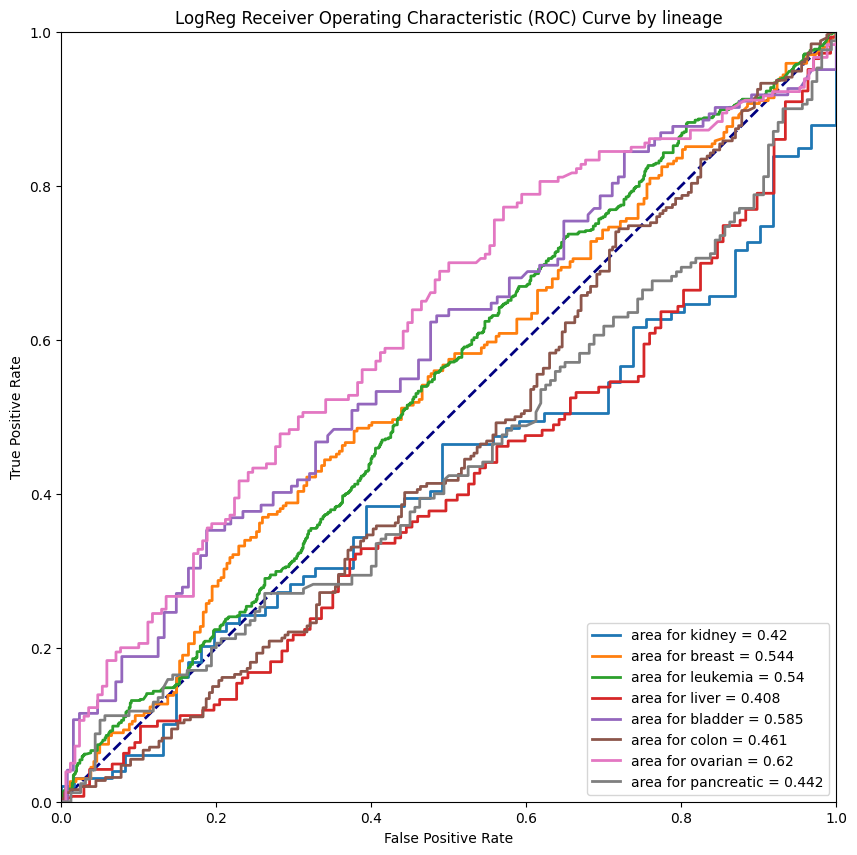

In [75]:
from sklearn.preprocessing import LabelBinarizer

plt.figure(figsize=(10, 10))
plt.title('LogReg Receiver Operating Characteristic (ROC) Curve by lineage')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.00])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for lineage, stats in stats_by_lineage.items():
    y_test_total = stats[2].flatten()
    y_pred_total = stats[3].flatten()
    y_pred_proba_total = stats[4].flatten()

    fpr, tpr, thresholds = roc_curve(y_test_total, y_pred_proba_total, pos_label='positive')
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'area for {lineage} = {auc_score.round(3)}')

plt.legend(loc='lower right')
plt.savefig("lr.png")
plt.show()

0.45454545454545453
